Epoch 1 Validation Accuracy: 0.5
Epoch 2 Validation Accuracy: 0.6753246753246753
Epoch 3 Validation Accuracy: 0.6688311688311688
Epoch 4 Validation Accuracy: 0.6623376623376623
Epoch 5 Validation Accuracy: 0.6558441558441559
Epoch 6 Validation Accuracy: 0.6623376623376623
Epoch 7 Validation Accuracy: 0.6623376623376623
Epoch 8 Validation Accuracy: 0.6818181818181818
Epoch 9 Validation Accuracy: 0.6623376623376623
Epoch 10 Validation Accuracy: 0.6753246753246753
Epoch 11 Validation Accuracy: 0.6623376623376623
Epoch 12 Validation Accuracy: 0.6688311688311688
Epoch 13 Validation Accuracy: 0.6558441558441559
Epoch 14 Validation Accuracy: 0.6623376623376623
Epoch 15 Validation Accuracy: 0.6688311688311688
Epoch 16 Validation Accuracy: 0.6558441558441559
Epoch 17 Validation Accuracy: 0.6818181818181818
Epoch 18 Validation Accuracy: 0.6493506493506493
Epoch 19 Validation Accuracy: 0.6493506493506493
Epoch 20 Validation Accuracy: 0.6623376623376623
Epoch 21 Validation Accuracy: 0.662337662337

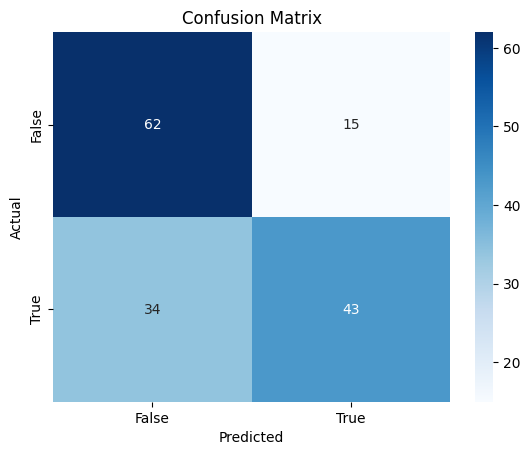

In [135]:
#imports 
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


# read in data, and then split our cateorical and numerical columns, then isolate our target column
df = pd.read_csv("data.csv")
categorical = ['date', 'qtr', 'shot_type', 'opponent', 'team', 'season', 'color', 'time_remaining']
numerical = ['top', 'left', 'distance_ft', 'lebron_team_score', 'opponent_team_score']
target = 'result'

#we seperate categorical and numerical because we need to pre process the categorical a little more
x_categorical = df[categorical]
x_numerical = df[numerical]
y = df[target]

#normalize data and then transform the data
scaler = StandardScaler()
x_numerical = scaler.fit_transform(x_numerical)

# we need to convert our categorical data as well
encoder = OneHotEncoder(sparse_output=False)
x_categorical_encoded = encoder.fit_transform(x_categorical)

# split the data into testing and training
x_train, x_test, y_train, y_test = train_test_split(x_numerical, y, test_size=0.1, stratify=y, shuffle = True)

# we need to convert everything to a tensor now
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
x_categorical_tensor = torch.tensor(x_categorical_encoded, dtype=torch.float32)

# now combine the categorical and numerical x data
x_train = torch.cat((x_train_tensor, x_categorical_tensor[:x_train.shape[0]]), dim=1)
x_test = torch.cat((x_test_tensor, x_categorical_tensor[x_train.shape[0]:]), dim=1)

#make our model
class modelClass(nn.Module):
    def __init__(self, input_dim):
        super(modelClass, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  
            nn.ReLU(),
            nn.Linear(128, 256), 
            nn.ReLU(),
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),  
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 1), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


#make data readable to go into model then make an instance with that shape of data
input_dim = x_train.shape[1]
model = modelClass(input_dim)

#create dataloaders for our testing and training
train_loader = DataLoader(TensorDataset(x_train, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test_tensor), batch_size=32)

#variables we will use later along with our loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()
num_epochs = 100
running_loss = 0

#Pytorch training algorithm that will calculate loss and accuracy
#from official pytorch documentation and ISLP labs
for epoch in range(num_epochs):
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 1000 == 0:
            last_loss = running_loss / 1000  
            print("last loss " + str(last_loss))
            running_loss = 0.0
 
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predicted = (torch.sigmoid(output) > 0.5).float()
            total += target.size(0)
            correct += (predicted == target.view(-1, 1)).sum().item()

    accuracy = correct / total
    print("Epoch " + str(epoch+1) + " Validation Accuracy: " + str(accuracy))

#get the predictions and get them in the format we want
predictions = model(x_test)
predictions = (torch.sigmoid(predictions) > 0.5).float().detach().numpy()

#get the score overall of our accuracy from the model
accuracy = accuracy_score(y_test, predictions)
print("Overall Accuracy: " + str(accuracy))

# make a confusion matrix
cm = confusion_matrix(y_test, predictions)

# visual for conufsion matrix
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=['False', 'True'],yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


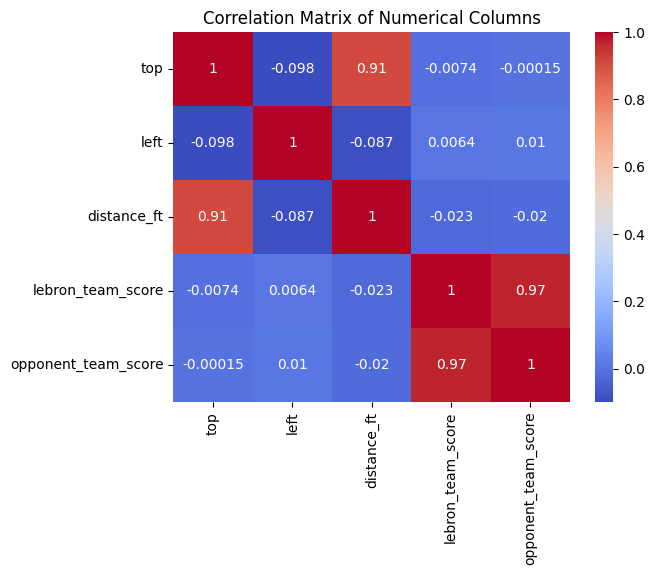

In [126]:
numerical_data = df[numerical]

correlation_matrix = numerical_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Columns')
plt.show()
